<a href="https://colab.research.google.com/github/yukismd/DL_for_ImageData_and_Finetuning/blob/main/text_classification_hatespeech/PT/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

sample_data


In [2]:
!pip install datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


In [3]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [4]:
!pip install fugashi unidic_lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic_lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=ae46bd446659522dbe80517689b5a1bf03b66e6fec741f05ecae8e58a5f4b1f6
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic_lite


In [5]:
import datasets
print(datasets.__version__)
import transformers
print(transformers.__version__)
from transformers import AutoTokenizer
#from transformers import AutoModelForSequenceClassification
#from transformers import DataCollatorWithPadding
import evaluate
print(evaluate.__version__)

import torch
#from torch.utils.data import DataLoader
#from torch.optim import AdamW
#from transformers import get_scheduler
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

#from tqdm.auto import tqdm

2.19.1
4.41.1
0.4.2


In [6]:
df = pd.read_csv('https://sample-data-open.s3.ap-northeast-1.amazonaws.com/text_classification_hatespeech/hatespeech_train.csv')
print(df.shape)
df.head()

(4656, 5)


,id,source,text,label,hold
0,b1b0d5e6c,newsplus,手引きしたのは高い確率で大院君だよなぁ,0,2
1,a5e29c5f1,livejupiter,いや別にワイが困るわけじゃないからええけど対応大変やなぁと思ってな,0,1
2,bd72cb57e,newsplus,そこで家族会すら総スカンを食らった極左を出すあたり頭が逝ってるな\n結局動かぬ証拠だから動か...,0,4
3,66387bae8,news4vip,もともとB'zが好きだったんだが松本のソロアルバムでtake5カバーしててな\nそれで原曲聴...,0,1
4,b80dc3a94,livejupiter,スタンドって本体の内面現すんだよな\n\nいろいろ想像するとおもろいわ\n何でDIOは時止め...,0,2


In [7]:
df_train = df[df['hold'] != 0]
df_valid = df[df['hold'] == 0]
df_train.shape, df_valid.shape

((3759, 5), (897, 5))

In [8]:
ds_train = datasets.Dataset.from_pandas(df_train[['text','label']], preserve_index=False)
ds_valid = datasets.Dataset.from_pandas(df_valid[['text','label']], preserve_index=False)

In [9]:
ds_train

Dataset({
    features: ['text', 'label'],
    num_rows: 3759
})

In [10]:
ds_valid

Dataset({
    features: ['text', 'label'],
    num_rows: 897
})

In [11]:
MODEL = 'tohoku-nlp/bert-large-japanese-v2'
N_CLASSES = 2
N_EPOCH = 2
LR = 0.000003  # 3e-5

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)
tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

BertJapaneseTokenizer(name_or_path='tohoku-nlp/bert-large-japanese-v2', vocab_size=32768, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["text"],
                     truncation=True,
                     max_length=128)    # 学習データの文長が短いので128に設定

In [14]:
ds_tkn_train = ds_train.map(tokenize_function, batched=True)
ds_tkn_valid = ds_valid.map(tokenize_function, batched=True)
ds_tkn_train, ds_tkn_valid

Parameter 'function'=<function tokenize_function at 0x7f7c455cf0a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/3759 [00:00<?, ? examples/s]

Map:   0%|          | 0/897 [00:00<?, ? examples/s]

(Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 3759
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 897
 }))

In [15]:
ds_tkn_train[0]

{'text': '手引きしたのは高い確率で大院君だよなぁ',
 'label': 0,
 'input_ids': [2,
  2391,
  19365,
  441,
  449,
  464,
  465,
  13034,
  18264,
  457,
  1588,
  7919,
  1226,
  450,
  490,
  460,
  7831,
  3],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

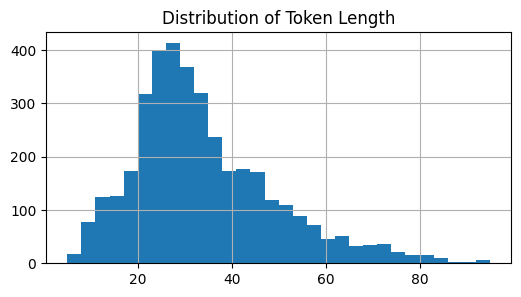

In [16]:
plt.figure(figsize=(6, 3))
pd.Series([len(i) for i in ds_tkn_train['input_ids']]).hist(bins=30)
plt.title('Distribution of Token Length')
plt.show()

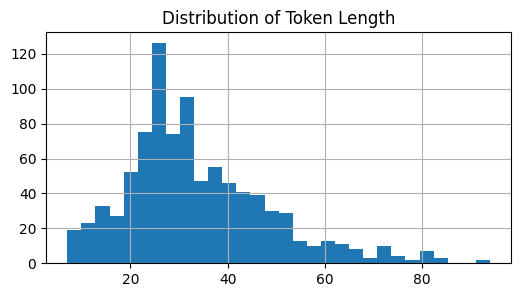

In [17]:
plt.figure(figsize=(6, 3))
pd.Series([len(i) for i in ds_tkn_valid['input_ids']]).hist(bins=30)
plt.title('Distribution of Token Length')
plt.show()

In [18]:
# textカラムの削除
ds_tkn_train = ds_tkn_train.remove_columns(['text'])
ds_tkn_valid = ds_tkn_valid.remove_columns(['text'])

# labelカラムをlabelsへリネーム
ds_tkn_train = ds_tkn_train.rename_column('label', 'labels')
ds_tkn_valid = ds_tkn_valid.rename_column('label', 'labels')

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL,
                                                           num_labels=N_CLASSES)

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tohoku-nlp/bert-large-japanese-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
trainer_args = TrainingArguments(
    seed=123,
    output_dir=".",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_steps=1e6, # saveのステップを大きくしてここではモデルの保存を行わないようにする
    log_level="critical",
    num_train_epochs=N_EPOCH,
    learning_rate=LR,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=12,
    save_total_limit=1,
    fp16=True,
    remove_unused_columns=False,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
metric = evaluate.load("f1")
metric

EvaluationModule(name: "f1", module_type: "metric", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    labels (`list` of `int`): The set of labels to include when `average` is not set to `'binary'`, and the order of the labels if `average` is `None`. Labels present in the data can be excluded, for example to calculate a multiclass average ignoring a majority negative class. Labels not present in the data will result in 0 components in a macro average. For multilabel targets, labels are column indices. By default, all labels in `predictions` and `references` are used in sorted order. Defaults to None.
    pos_label (`int`): The class to be considered the positive class, in the case where `average` is set to `binary`. Defaults to 1.
    average (`string`): This parameter is required for multiclass/multilabel t

In [22]:
# 精度評価関数
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [23]:
# 精度評価関数
'''
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    result = f1_score(p.label_ids, preds)
    return {"f1_score":result}

'''

'\ndef compute_metrics(p: EvalPrediction):\n    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions\n    preds = np.argmax(preds, axis=1)\n    result = f1_score(p.label_ids, preds)\n    return {"f1_score":result}\n\n'

In [24]:
trainer = Trainer(
    model=model,
    args=trainer_args,
    tokenizer=tokenizer,
    train_dataset=ds_tkn_train,
    eval_dataset=ds_tkn_valid,
    compute_metrics=compute_metrics,
)

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.233800,0.136370,0.275862
2,0.123600,0.118153,0.589474


TrainOutput(global_step=940, training_loss=0.17866662613889003, metrics={'train_runtime': 307.5204, 'train_samples_per_second': 24.447, 'train_steps_per_second': 3.057, 'total_flos': 793264708928748.0, 'train_loss': 0.17866662613889003, 'epoch': 2.0})

In [26]:
df_test = pd.read_csv('https://sample-data-open.s3.ap-northeast-1.amazonaws.com/text_classification_hatespeech/hatespeech_test.csv')
print(df_test.shape)
df_test.head()

(600, 4)


,id,source,text,label
0,e3d3e578b,news4vip,まぁ、俺の言ってることは余りあてにしないでくれwwww\n\n必ずいい人は現れるよ,0
1,a728f26db,news4vip,すまないがそれはレンジのほうか？\nそれともトースター？,0
2,c53e66dc9,livejupiter,そら大不況で独り勝ちした金持ちを殺してしかも自分もちゃんと腹切ってるからな\n今で言うならリ...,0
3,fb3b600fb,newsplus,外国や外国人に税金や公的資金を使うのは違法と言ってくれたら、民進党の支持率は爆上げだろうな。,0
4,ef9cd1326,newsplus,中国人は、日本の年金制度にものらないとw,0


In [42]:
ds_test = datasets.Dataset.from_pandas(df_test[['text','label']], preserve_index=False)

In [43]:
ds_tkn_test = ds_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [44]:
ds_tkn_test

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 600
})

In [45]:
# textカラムの削除
ds_tkn_test = ds_tkn_test.remove_columns(['text'])

# labelカラムをlabelsへリネーム
ds_tkn_test = ds_tkn_test.rename_column('label', 'labels')

In [46]:
test_preds = trainer.predict(ds_tkn_test)

In [47]:
test_preds

PredictionOutput(predictions=array([[ 3.9648438, -4.1015625],
       [ 3.90625  , -4.4414062],
       [ 3.5605469, -4.4335938],
       ...,
       [ 3.46875  , -3.7890625],
       [ 3.1386719, -3.0273438],
       [ 3.9628906, -4.34375  ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
    

In [48]:
test_preds.metrics

{'test_loss': 0.15791480243206024,
 'test_f1': 0.5797101449275363,
 'test_runtime': 2.1514,
 'test_samples_per_second': 278.882,
 'test_steps_per_second': 23.24}

In [49]:
test_preds.predictions.shape

(600, 2)

In [51]:
type(test_preds.predictions)

numpy.ndarray

In [50]:
test_preds.predictions

array([[ 3.9648438, -4.1015625],
       [ 3.90625  , -4.4414062],
       [ 3.5605469, -4.4335938],
       ...,
       [ 3.46875  , -3.7890625],
       [ 3.1386719, -3.0273438],
       [ 3.9628906, -4.34375  ]], dtype=float32)